In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
<a href="javascript:code_toggle_err()"><button>here</button></a>''')

In [2]:
import os
import sys
import pandas as pd
import csv
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
from sklearn.linear_model import Ridge,LogisticRegression
# stack_clf = LogisticRegression(n_jobs=-1)
ridge_clf = Ridge(alpha=1.0)

In [4]:
from xgboost import XGBRegressor,plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import Normalizer
import xgboost as xgb

In [5]:
from matplotlib import pyplot
%matplotlib inline

In [6]:
from mlxtend.regressor import StackingRegressor

In [7]:
data_folder = '../data'
data_files = os.listdir(data_folder)

In [8]:
year_new = pd.read_csv("../merged_data.csv")
year_new.head()

,Hour,GHI,Temperature,Pressure,Relative Humidity,Wind Speed
0,0,0,12.751340,957.930542,58.411399,4.430836
1,1,0,12.196895,957.762268,67.295928,4.453419
2,2,0,11.806139,957.878052,72.567490,4.335502
3,3,0,11.510596,957.623596,75.299340,4.233897
4,4,0,11.306807,957.932861,76.799288,4.197238


In [ ]:
new_columns = year_2014.iloc[1]
year_all = year_2014[2:]
year_all.columns =new_columns
year = year_all.loc[:, year_all.columns.notnull()]

year = year.drop(columns=['Year','Month','Day','Minute','DHI','DNI','Clearsky DHI','Clearsky DNI','Fill Flag','Dew Point','Clearsky GHI','Solar Zenith Angle','Wind Direction','Snow Depth','Precipitable Water'])

year = year.astype('float64')
year.info()

In [9]:
X = year_new.drop(columns=['GHI'])
Y = year_new.pop('GHI')

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

## Models selections 
As using GridSearchCV gives us the best parameter as n_estimators = 10, max_depth = 3 and learning rate = 0.4
so, we will define forest around these parameter values

## forest Number 1 :: 5 xgboost trees 

In [10]:
xgb_1 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=8)
xgb_2 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=9)
xgb_3 = XGBRegressor(learning_rate=0.4,max_depth=8,n_estimators=10)
xgb_4 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=9)
xgb_5 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=8)

In [11]:
xgb_1.fit(X_train,y_train)
xgb_2.fit(X_train,y_train)
xgb_3.fit(X_train,y_train)
xgb_4.fit(X_train,y_train)
xgb_5.fit(X_train,y_train)

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.4, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=8, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [12]:
predicted_xgb_1 = xgb_1.predict(X_train)
predicted_xgb_2 = xgb_2.predict(X_train)
predicted_xgb_3 = xgb_3.predict(X_train)
predicted_xgb_4 = xgb_4.predict(X_train)
predicted_xgb_5 = xgb_5.predict(X_train)

In [13]:
score = {}

models = [xgb_1,xgb_2,xgb_3,xgb_4,xgb_5]
for counter1,model in enumerate(models):
    predictinos = model.predict(X_test)
    squared_sum = 0
    for counter,i in enumerate(y_test):
        squared_sum += ((i)-predictinos[counter])**2
    score["xgb_"+str(counter1+1)] = (math.sqrt(squared_sum/len(y_test)))  

print(score)

In [17]:
df_pred = pd.DataFrame({
    'xgb_1':predicted_xgb_1,
    'xgb_2':predicted_xgb_2,
    'xgb_3':predicted_xgb_3,
    'xgb_4':predicted_xgb_4,
    'xgb_5':predicted_xgb_5,
})
X_train, X_test, y_train, y_test = train_test_split(df_pred, y_train, test_size=test_size, random_state=seed)

In [18]:
ridge_clf.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
predictinos = ridge_clf.predict(X_test)
print(predictinos)
squared_sum = 0
for counter,i in enumerate(y_test):
    squared_sum += ((i)-predictinos[counter])**2
print(math.sqrt(squared_sum/len(y_test))) 

[ 1.88885528e-01 -1.54308437e+00  5.80191974e+02 ...  2.16392542e+00
 -5.67296849e-01  4.42690238e+02]
48.602648134408994


In [27]:
min_x_test = y_test[0:100]
predictinos = ridge_clf.predict(X_test)[0:100]

In [54]:
original_y_test = []
x = []
for counter,i in enumerate(min_x_test):
    original_y_test.append(i)
    x.append(counter)

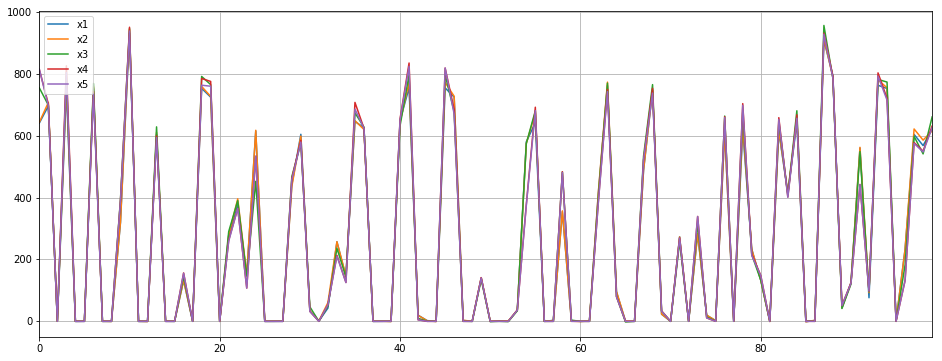

In [67]:
df_plot = df_pred[0:100]
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(ax=ax)
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()


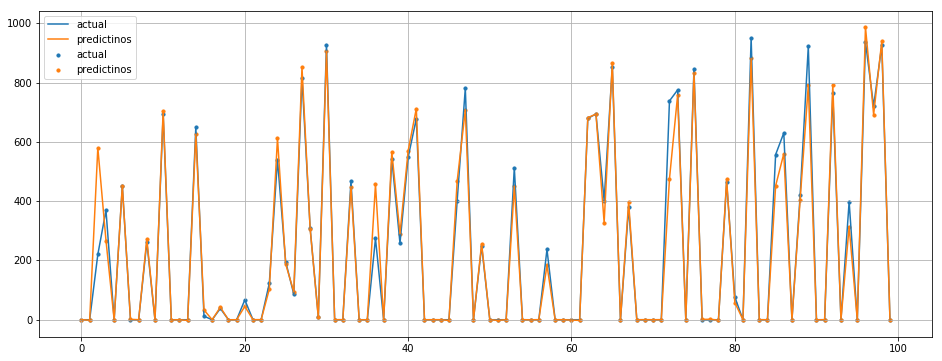

In [53]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(original_y_test,linewidth=1.5,label="actual")
ax.scatter(x,original_y_test,s=10,label="actual")
ax.plot(predictinos,linewidth=1.5,label="predictinos")
ax.scatter(x,predictinos,s=10,label="predictinos")
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()

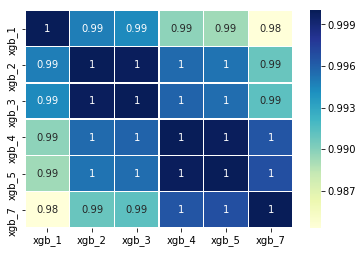

In [76]:
corr_hm = sns.heatmap(df_pred.corr(), 
                xticklabels=df_pred.corr().columns,
                yticklabels=df_pred.corr().columns,
                vmax=1,
                cmap="YlGnBu",
                annot=True,
                linewidths=.5
                     )
plt.show()

# forest Number 2 :: 7 xgboost trees 

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'xgb_1': 80.21868469248788, 'xgb_2': 70.39461470053246, 'xgb_3': 69.73257848752506, 'xgb_4': 68.97220779229859, 'xgb_5': 71.26762856647856, 'xgb_6': 71.52672627989328, 'xgb_7': 72.23083193065277}
forest rmse: 31.355123063783186


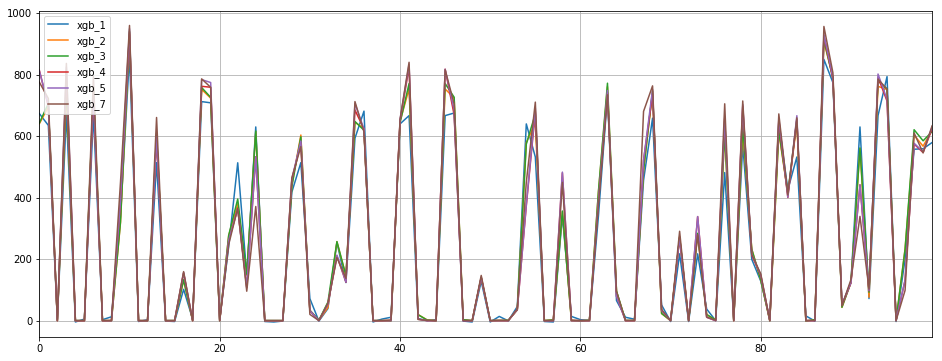

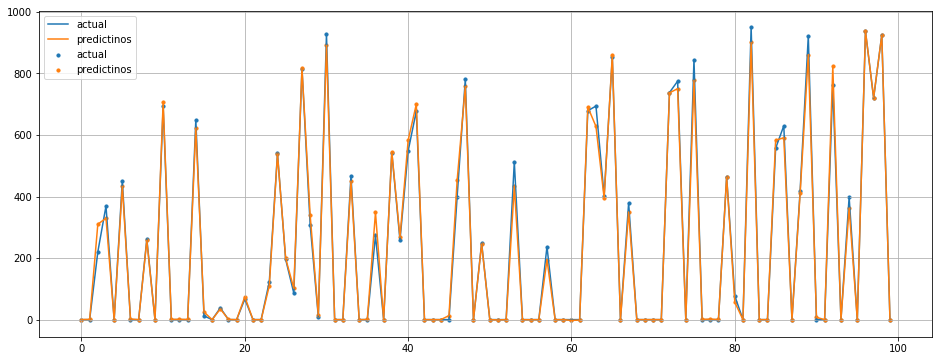

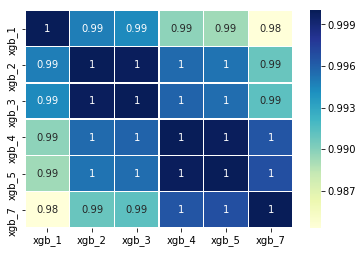

In [77]:
year_new = pd.read_csv("../merged_data.csv")
X = year_new.drop(columns=['GHI'])
Y = year_new.pop('GHI')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

xgb_1 = XGBRegressor(learning_rate=0.4,max_depth=4,n_estimators=6)
xgb_2 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=8)
xgb_3 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=9)
xgb_4 = XGBRegressor(learning_rate=0.4,max_depth=8,n_estimators=10)
xgb_5 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=9)
xgb_6 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=8)
xgb_7 = XGBRegressor(learning_rate=0.4,max_depth=12,n_estimators=12)

xgb_1.fit(X_train,y_train)
xgb_2.fit(X_train,y_train)
xgb_3.fit(X_train,y_train)
xgb_4.fit(X_train,y_train)
xgb_5.fit(X_train,y_train)
xgb_6.fit(X_train,y_train)
xgb_7.fit(X_train,y_train)

predicted_xgb_1 = xgb_1.predict(X_train)
predicted_xgb_2 = xgb_2.predict(X_train)
predicted_xgb_3 = xgb_3.predict(X_train)
predicted_xgb_4 = xgb_4.predict(X_train)
predicted_xgb_5 = xgb_5.predict(X_train)
predicted_xgb_6 = xgb_6.predict(X_train)
predicted_xgb_7 = xgb_7.predict(X_train)

score = {}
models = [xgb_1,xgb_2,xgb_3,xgb_4,xgb_5,xgb_6,xgb_7]
for counter1,model in enumerate(models):
    predictinos = model.predict(X_test)
    squared_sum = 0
    for counter,i in enumerate(y_test):
        squared_sum += ((i)-predictinos[counter])**2
    score["xgb_"+str(counter1+1)] = (math.sqrt(squared_sum/len(y_test)))  
print(score)


df_pred = pd.DataFrame({
    'xgb_1':predicted_xgb_1,
    'xgb_2':predicted_xgb_2,
    'xgb_3':predicted_xgb_3,
    'xgb_4':predicted_xgb_4,
    'xgb_5':predicted_xgb_5,
    'xgb_4':predicted_xgb_6,
    'xgb_7':predicted_xgb_7,
})
X_train, X_test, y_train, y_test = train_test_split(df_pred, y_train, test_size=test_size, random_state=seed)

ridge_clf.fit(X_train,y_train)

predictinos = ridge_clf.predict(X_test)
squared_sum = 0
for counter,i in enumerate(y_test):
    squared_sum += ((i)-predictinos[counter])**2
print("forest rmse: " + str(math.sqrt(squared_sum/len(y_test))))

min_x_test = y_test[0:100]
predictinos = ridge_clf.predict(X_test)[0:100]

original_y_test = []
x = []
for counter,i in enumerate(min_x_test):
    original_y_test.append(i)
    x.append(counter)

    
df_plot = df_pred[0:100]
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(ax=ax)
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()


fig, ax = plt.subplots(figsize=(16,6))
ax.plot(original_y_test,linewidth=1.5,label="actual")
ax.scatter(x,original_y_test,s=10,label="actual")
ax.plot(predictinos,linewidth=1.5,label="predictinos")
ax.scatter(x,predictinos,s=10,label="predictinos")
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()

corr_hm = sns.heatmap(df_pred.corr(), 
                xticklabels=df_pred.corr().columns,
                yticklabels=df_pred.corr().columns,
                vmax=1,
                cmap="YlGnBu",
                annot=True,
                linewidths=.5)
plt.show()

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'xgb_1': 167.0442332618987, 'xgb_2': 80.21868469248788, 'xgb_3': 70.39461470053246, 'xgb_4': 69.73257848752506, 'xgb_5': 68.97220779229859, 'xgb_6': 71.26762856647856, 'xgb_7': 71.52672627989328, 'xgb_8': 72.23083193065277, 'xgb_9': 73.69342781905075}
forest rmse: 15.299012777173003


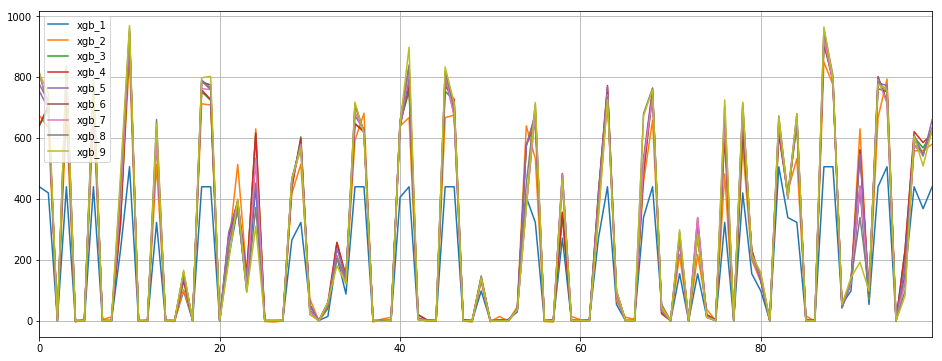

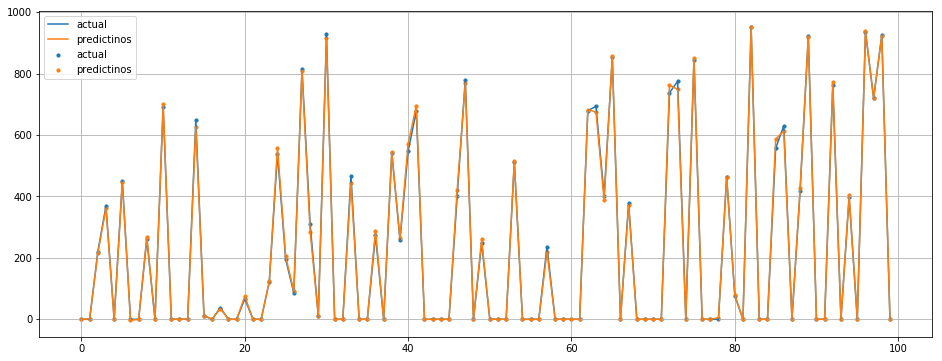

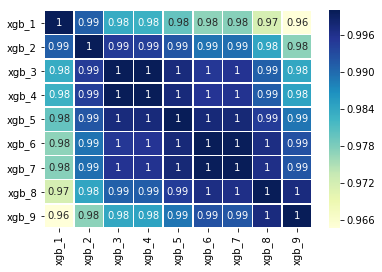

In [78]:
year_new = pd.read_csv("../merged_data.csv")
X = year_new.drop(columns=['GHI'])
Y = year_new.pop('GHI')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

xgb_1 = XGBRegressor(learning_rate=0.4,max_depth=4,n_estimators=2)
xgb_2 = XGBRegressor(learning_rate=0.4,max_depth=4,n_estimators=6)
xgb_3 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=8)
xgb_4 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=9)
xgb_5 = XGBRegressor(learning_rate=0.4,max_depth=8,n_estimators=10)
xgb_6 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=9)
xgb_7 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=8)
xgb_8 = XGBRegressor(learning_rate=0.4,max_depth=12,n_estimators=12)
xgb_9 = XGBRegressor(learning_rate=0.4,max_depth=15,n_estimators=20)

xgb_1.fit(X_train,y_train)
xgb_2.fit(X_train,y_train)
xgb_3.fit(X_train,y_train)
xgb_4.fit(X_train,y_train)
xgb_5.fit(X_train,y_train)
xgb_6.fit(X_train,y_train)
xgb_7.fit(X_train,y_train)
xgb_8.fit(X_train,y_train)
xgb_9.fit(X_train,y_train)

predicted_xgb_1 = xgb_1.predict(X_train)
predicted_xgb_2 = xgb_2.predict(X_train)
predicted_xgb_3 = xgb_3.predict(X_train)
predicted_xgb_4 = xgb_4.predict(X_train)
predicted_xgb_5 = xgb_5.predict(X_train)
predicted_xgb_6 = xgb_6.predict(X_train)
predicted_xgb_7 = xgb_7.predict(X_train)
predicted_xgb_8 = xgb_8.predict(X_train)
predicted_xgb_9 = xgb_9.predict(X_train)

score = {}
models = [xgb_1,xgb_2,xgb_3,xgb_4,xgb_5,xgb_6,xgb_7,xgb_8,xgb_9]
for counter1,model in enumerate(models):
    predictinos = model.predict(X_test)
    squared_sum = 0
    for counter,i in enumerate(y_test):
        squared_sum += ((i)-predictinos[counter])**2
    score["xgb_"+str(counter1+1)] = (math.sqrt(squared_sum/len(y_test)))  
print(score)


df_pred = pd.DataFrame({
    'xgb_1':predicted_xgb_1,
    'xgb_2':predicted_xgb_2,
    'xgb_3':predicted_xgb_3,
    'xgb_4':predicted_xgb_4,
    'xgb_5':predicted_xgb_5,
    'xgb_6':predicted_xgb_6,
    'xgb_7':predicted_xgb_7,
    'xgb_8':predicted_xgb_8,
    'xgb_9':predicted_xgb_9,
})
X_train, X_test, y_train, y_test = train_test_split(df_pred, y_train, test_size=test_size, random_state=seed)

ridge_clf.fit(X_train,y_train)

predictinos = ridge_clf.predict(X_test)
squared_sum = 0
for counter,i in enumerate(y_test):
    squared_sum += ((i)-predictinos[counter])**2
print("forest rmse: " + str(math.sqrt(squared_sum/len(y_test))))

min_x_test = y_test[0:100]
predictinos = ridge_clf.predict(X_test)[0:100]

original_y_test = []
x = []
for counter,i in enumerate(min_x_test):
    original_y_test.append(i)
    x.append(counter)

    
df_plot = df_pred[0:100]
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(ax=ax)
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()


fig, ax = plt.subplots(figsize=(16,6))
ax.plot(original_y_test,linewidth=1.5,label="actual")
ax.scatter(x,original_y_test,s=10,label="actual")
ax.plot(predictinos,linewidth=1.5,label="predictinos")
ax.scatter(x,predictinos,s=10,label="predictinos")
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()

corr_hm = sns.heatmap(df_pred.corr(), 
                xticklabels=df_pred.corr().columns,
                yticklabels=df_pred.corr().columns,
                vmax=1,
                cmap="YlGnBu",
                annot=True,
                linewidths=.5)
plt.show()

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'xgb_1': 235.46429870809266, 'xgb_2': 112.9183629076269, 'xgb_3': 104.52287188676121, 'xgb_4': 104.13691997464937, 'xgb_5': 103.32148607132785, 'xgb_6': 105.85983129419186, 'xgb_7': 106.0613164845042, 'xgb_8': 109.37997144050001, 'xgb_9': 112.59331579055606, 'xgb_10': 105.74103909303675, 'xgb_11': 109.1070211317737}
forest rmse: 14.625078841232089


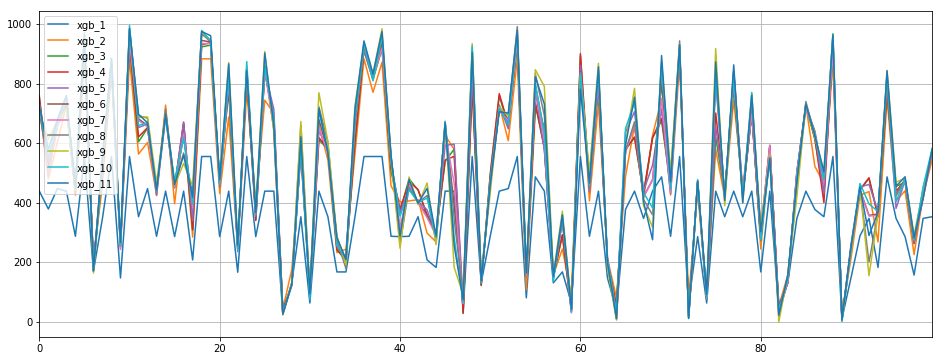

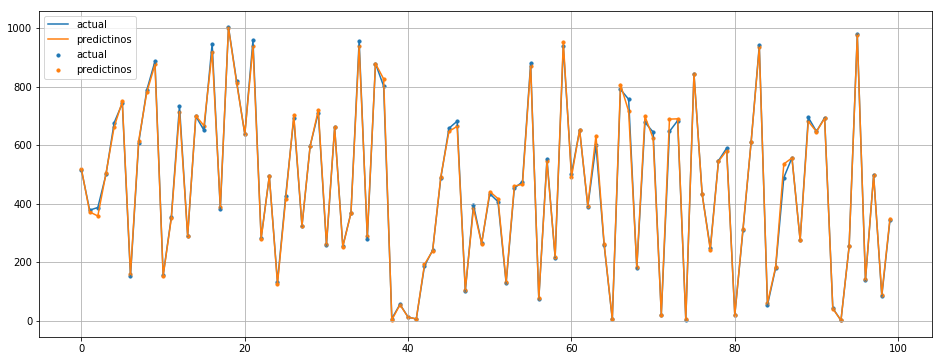

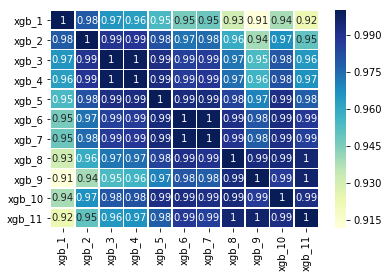

In [79]:
year_new = pd.read_csv("../11_hour_merged_data.csv")
X = year_new.drop(columns=['GHI'])
Y = year_new.pop('GHI')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

xgb_1 = XGBRegressor(learning_rate=0.4,max_depth=4,n_estimators=2)
xgb_2 = XGBRegressor(learning_rate=0.4,max_depth=4,n_estimators=6)
xgb_3 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=8)
xgb_4 = XGBRegressor(learning_rate=0.4,max_depth=6,n_estimators=9)
xgb_5 = XGBRegressor(learning_rate=0.4,max_depth=8,n_estimators=10)
xgb_6 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=9)
xgb_7 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=8)
xgb_8 = XGBRegressor(learning_rate=0.4,max_depth=12,n_estimators=12)
xgb_9 = XGBRegressor(learning_rate=0.4,max_depth=15,n_estimators=20)
xgb_10 = XGBRegressor(learning_rate=0.4,max_depth=8,n_estimators=35)
xgb_11 = XGBRegressor(learning_rate=0.4,max_depth=10,n_estimators=40)

xgb_1.fit(X_train,y_train)
xgb_2.fit(X_train,y_train)
xgb_3.fit(X_train,y_train)
xgb_4.fit(X_train,y_train)
xgb_5.fit(X_train,y_train)
xgb_6.fit(X_train,y_train)
xgb_7.fit(X_train,y_train)
xgb_8.fit(X_train,y_train)
xgb_9.fit(X_train,y_train)
xgb_10.fit(X_train,y_train)
xgb_11.fit(X_train,y_train)

predicted_xgb_1 = xgb_1.predict(X_train)
predicted_xgb_2 = xgb_2.predict(X_train)
predicted_xgb_3 = xgb_3.predict(X_train)
predicted_xgb_4 = xgb_4.predict(X_train)
predicted_xgb_5 = xgb_5.predict(X_train)
predicted_xgb_6 = xgb_6.predict(X_train)
predicted_xgb_7 = xgb_7.predict(X_train)
predicted_xgb_8 = xgb_8.predict(X_train)
predicted_xgb_9 = xgb_9.predict(X_train)
predicted_xgb_10 = xgb_10.predict(X_train)
predicted_xgb_11 = xgb_11.predict(X_train)

score = {}
models = [xgb_1,xgb_2,xgb_3,xgb_4,xgb_5,xgb_6,xgb_7,xgb_8,xgb_9,xgb_10,xgb_11]
for counter1,model in enumerate(models):
    predictinos = model.predict(X_test)
    squared_sum = 0
    for counter,i in enumerate(y_test):
        squared_sum += ((i)-predictinos[counter])**2
    score["xgb_"+str(counter1+1)] = (math.sqrt(squared_sum/len(y_test)))  
print(score)


df_pred = pd.DataFrame({
    'xgb_1':predicted_xgb_1,
    'xgb_2':predicted_xgb_2,
    'xgb_3':predicted_xgb_3,
    'xgb_4':predicted_xgb_4,
    'xgb_5':predicted_xgb_5,
    'xgb_6':predicted_xgb_6,
    'xgb_7':predicted_xgb_7,
    'xgb_8':predicted_xgb_8,
    'xgb_9':predicted_xgb_9,
    'xgb_10':predicted_xgb_10,
    'xgb_11':predicted_xgb_11,
})
X_train, X_test, y_train, y_test = train_test_split(df_pred, y_train, test_size=test_size, random_state=seed)

ridge_clf.fit(X_train,y_train)

predictinos = ridge_clf.predict(X_test)
squared_sum = 0
for counter,i in enumerate(y_test):
    squared_sum += ((i)-predictinos[counter])**2
print("forest rmse: " + str(math.sqrt(squared_sum/len(y_test))))

min_x_test = y_test[0:100]
predictinos = ridge_clf.predict(X_test)[0:100]

original_y_test = []
x = []
for counter,i in enumerate(min_x_test):
    original_y_test.append(i)
    x.append(counter)

    
df_plot = df_pred[0:100]
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(ax=ax)
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()


fig, ax = plt.subplots(figsize=(16,6))
ax.plot(original_y_test,linewidth=1.5,label="actual")
ax.scatter(x,original_y_test,s=10,label="actual")
ax.plot(predictinos,linewidth=1.5,label="predictinos")
ax.scatter(x,predictinos,s=10,label="predictinos")
ax.grid(True)
ax.legend(loc='upper left',)
plt.show()

corr_hm = sns.heatmap(df_pred.corr(), 
                xticklabels=df_pred.corr().columns,
                yticklabels=df_pred.corr().columns,
                vmax=1,
                cmap="YlGnBu",
                annot=True,
                linewidths=.5)
plt.show()